In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from pydub import AudioSegment
import cv2
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# converts an AudioSegment to NumPy array
def audiosegment_to_np(audio_segment):
    samples = np.array(audio_segment.get_array_of_samples())
    if audio_segment.channels == 2:
        samples = samples.reshape((-1, 2))
        samples = samples.mean(axis=1)  # Convert stereo to mono
    return samples

# loads audio file using PyDub and convert it to a NumPy array
def load_audio(filepath):
    audio = AudioSegment.from_file(filepath)
    sample_rate = audio.frame_rate
    samples = audiosegment_to_np(audio)
    return sample_rate, samples

# computes STFT and return frequency, time, and magnitude
def compute_stft(samples, sample_rate, nperseg=1024):
    frequencies, times, Zxx = stft(samples, fs=sample_rate, nperseg=nperseg)
    magnitude = np.abs(Zxx)
    
    return frequencies, times, magnitude

# create a 3D plot for a specific time slice
def plot_3d_frame(ax, frequencies, times, magnitude, time_idx):
    ax.clear()
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_zlabel('Magnitude (Log Scale)')
    ax.set_title(f'3D Spectrogram at Time: {times[time_idx]:.2f}s')
    
    # plots the surface up to the current time index
    T, F = np.meshgrid(times[:time_idx+1], frequencies)
    
    # apply logarithmic scale to the magnitude to highlight smaller values
    log_magnitude = np.log10(magnitude + 1)
    
    # plot the 3D surface with a color map and no edge color for clarity
    ax.plot_surface(T, F, log_magnitude[:, :time_idx+1], cmap='inferno', edgecolor='none')
    
    # remove the grid and set background to white for better contrast
    ax.grid(False)
    ax.set_facecolor((1, 1, 1, 0))

# generate and save a video of the 3D spectrogram
def generate_3d_spectrogram_video(frequencies, times, magnitude, output_filename, fps, audio_duration):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # set up video writer using OpenCV, calculate frames
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_filename, fourcc, fps, (1280, 720))

    total_frames = int(audio_duration * fps)
    
    # loop though time indices, converting and writing to mp4
    for time_idx in np.linspace(0, len(times) - 1, total_frames).astype(int):
        plot_3d_frame(ax, frequencies, times, magnitude, time_idx)
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
        image_resized = cv2.resize(image, (1280, 720))
        
        video_writer.write(image_resized)

    # Release the video writer
    video_writer.release()

# main function to load audio, compute STFT, and generate the video
def visualize_3d_audio_to_video(filepath, output_filename='output.mp4', fps=30):
    sample_rate, samples = load_audio(filepath)
    frequencies, times, magnitude = compute_stft(samples, sample_rate)
    
    
    audio_duration = len(samples) / sample_rate
    
    
    generate_3d_spectrogram_video(frequencies, times, magnitude, output_filename, fps, audio_duration)




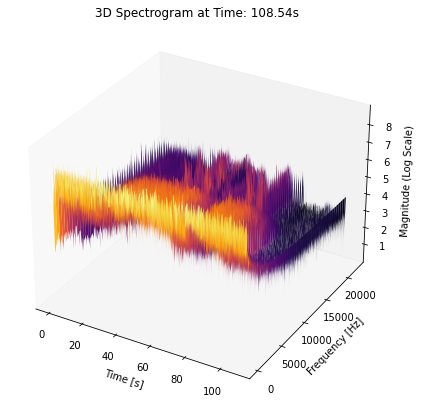

In [6]:
path= '/Users/georgeanders/Downloads/break_ambient.wav'

visualize_3d_audio_to_video(path)